# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import re
import math
import json
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
% matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Load and Clean Dataset

### 1.1 Portfolio Dataset

### Show Data

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


### Data Shape

In [3]:
portfolio.shape # Show the shape of the dataset

(10, 6)

### Data Types

In [4]:
portfolio.info() # Show the data_types of features 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


### Data Completeness

In [5]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

There no missing value is portfolio dataset.

### Descriptive Statistics

In [6]:
portfolio.describe().round().T # Summary Statistics

,count,mean,std,min,25%,50%,75%,max
difficulty,10.0,8.0,6.0,0.0,5.0,8.0,10.0,20.0
duration,10.0,6.0,2.0,3.0,5.0,7.0,7.0,10.0
reward,10.0,4.0,4.0,0.0,2.0,4.0,5.0,10.0


### Data cleaning, Preprocessing, and feature extraction

The cleaning and preprocessing of portfolio is performed as follow :
- Change the names of id to be more readable.
- The channels columns require to be one-hot encoded.
- Add offer name rather than only using offer ids for interpretation later on. The offer will be named as offer_number. For example, offer_1 means offer type of bogo with difficulty of 10 ,reward of 10 dollars ,reward of 10 dollars and duration for 7 days.

In [7]:
# Change the names of id to be more readable 
id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'BOGO_1','4d5c57ea9a6940dd891ad53e9dbe8da0': 'BOGO_2',
      '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'BOGO_3','f19421c1d4aa40978ebb69ca19b0e20d': 'BOGO_4',
      '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'Discount_1','2298d6c36e964ae4a3e7e9706d1fb8c2': 'Discount-2',
      'fafdcd668e3743c1bb461111dcafc2a4': 'Discount_3','2906b810c7d4411798c6938adc9daaa5': 'Discount_4',
      '3f207df678b143eea3cee63160fa8bed': 'Info_1','5a8bc65990b245e5a138643cd4eb9837': 'info_2'}
portfolio.id = portfolio.id.apply(lambda x: id[x] if x else None)

In [8]:
# Extract names in channel 
channel_names = set() 
for channel in portfolio.channels:
    channel_names.update(channel)
channel_names 

{'email', 'mobile', 'social', 'web'}

In [9]:
for channel in channel_names:
    portfolio[channel]=[int (channel in x) for x in portfolio.channels]

In [10]:
portfolio.drop('channels', inplace=True, axis=1) # drop the channels column

In [11]:
portfolio['offer_Number']=["offer_"+ str(i) for i in range(1,portfolio.shape[0]+1)] # Add the offer_Number column  

In [12]:
portfolio.head(10) 

,difficulty,duration,id,offer_type,reward,social,web,mobile,email,offer_Number
0,10,7,BOGO_1,bogo,10,1,0,1,1,offer_1
1,10,5,BOGO_2,bogo,10,1,1,1,1,offer_2
2,0,4,Info_1,informational,0,0,1,1,1,offer_3
3,5,7,BOGO_3,bogo,5,0,1,1,1,offer_4
4,20,10,Discount_1,discount,5,0,1,0,1,offer_5
5,7,7,Discount-2,discount,3,1,1,1,1,offer_6
6,10,10,Discount_3,discount,2,1,1,1,1,offer_7
7,0,3,info_2,informational,0,1,0,1,1,offer_8
8,5,5,BOGO_4,bogo,5,1,1,1,1,offer_9
9,10,7,Discount_4,discount,2,0,1,1,1,offer_10


In [13]:
# sum for each channel columns
portfolio[['email','mobile','social','web']].sum() 

email     10
mobile     9
social     6
web        8
dtype: int64

Most of channels are used are email then followed by mobile. However, the email was used in all offer type.

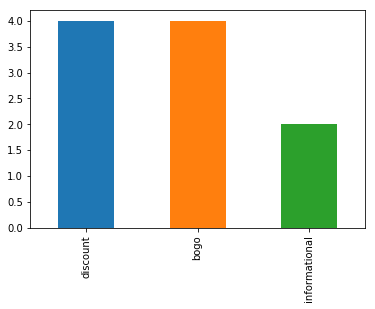

In [14]:
portfolio.offer_type.value_counts().plot(kind='bar')

We can see from the above graph that BOGOs and discounts are the most common types of offers

### 1.2 profile Dataset

### Show Data

In [15]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


### Data Shape

In [16]:
profile.shape # Show the shape of the dataset

(17000, 5)

### Data Types

In [17]:
profile.info() # Show the data_types of features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


### Data Completeness

In [18]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

There is a big missing value in dataset

In [19]:
print("There are",profile['id'].nunique(),"Customers in our dataset")

There are 17000 Customers in our dataset


### Descriptive Statistics

In [20]:
profile.describe().round().T # Summary Statistics

,count,mean,std,min,25%,50%,75%,max
age,17000.0,63.0,27.0,18.0,45.0,58.0,73.0,118.0
became_member_on,17000.0,20167034.0,11677.0,20130729.0,20160526.0,20170802.0,20171230.0,20180726.0
income,14825.0,65405.0,21598.0,30000.0,49000.0,64000.0,80000.0,120000.0


### Data cleaning, Preprocessing, and feature extraction

The cleaning and preprocessing of Profile is performed as follow :
- dropped all ages where value 118 because when the age == 118 the  income and gender are missing values .
- transformed the became_member_on column to a datetime object. 
- The gender columns require to be one-hot encoded.
- one hot encoded a customer’s age range.
- one hot encoded a customer’s income range. 


In [21]:
profile['male'] = profile.gender.apply(lambda x: 1 if x == 'M' else 0) 
profile['female'] = profile.gender.apply(lambda x: 1 if x == 'F' else 0)

In [22]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [23]:
profile[profile.age==118].head(2175)

,age,became_member_on,gender,id,income,male,female
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,0,0
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN,0,0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN,0,0
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN,0,0
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN,0,0
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN,0,0
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN,0,0


According to above, the missing values in gender and income are related to abnormal values in the age that is 118. Thus, all those values are removed from the dataset, So it needs to be deleted because it will have an effect on the accuracy of the data.

In [24]:
profile = profile.drop(profile[profile.age==118].index) # drop where age = 118

In [25]:
profile["gender"].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

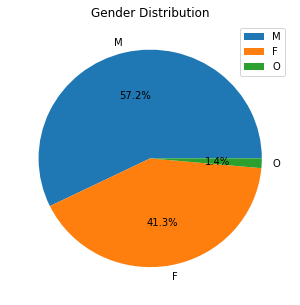

In [26]:
# Plot that show the percentage of Gender.
count_test = profile['gender'].value_counts()
labels = profile['gender'].value_counts().index
plt.figure(figsize=(5,5))
plt.pie(count_test, labels=labels, autopct='%1.1f%%')
plt.legend(labels)
plt.title("Gender Distribution")
plt.show()

The graph shows that males have the highest percentage of gender and they represent 57% then followed by females with 41%. There are small amount of ‘O’ around 14% cases do not have a defined gender.

Text(0.5,0,'age')

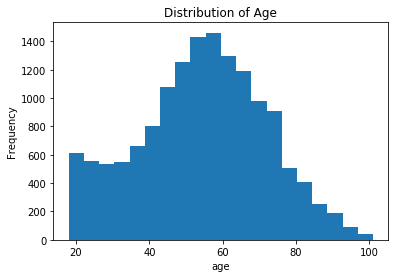

In [27]:
age_plot = profile['age'].plot(kind='hist', bins=20, title='Distribution of Age')
age_plot.set_xlabel("age")

In [28]:
print("THe Avg age of customer is:",profile.age.mean().round()) #Average age

THe Avg age of customer is: 54.0


Text(0.5,0,'income')

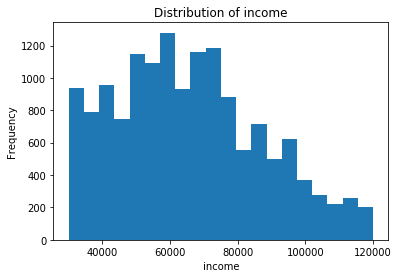

In [29]:
income_plot = profile['income'].plot(kind='hist', bins=20, title='Distribution of income')
income_plot.set_xlabel("income")

In [30]:
print("THe Avg income of customer is:",profile.income.mean().round()) #Average income

THe Avg income of customer is: 65405.0


In [31]:
bins = [0,12,20,30,40,50,60,70,200] 
labels = ['16-19','20-29','30-39','40-49','50-59','60-69','70-79','+80']
profile['age_range'] = pd.cut(profile.age, bins, labels = labels)
profile_age = profile.groupby(['age_range'], as_index=False)['id'].count()
profile_age

,age_range,id
0,16-19,0
1,20-29,340
2,30-39,1365
3,40-49,1597
4,50-59,2391
5,60-69,3590
6,70-79,2910
7,+80,2632


Text(0,0.5,'Total')

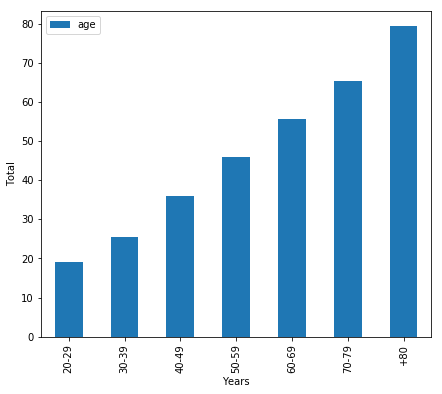

In [32]:
df_pivot = pd.pivot_table(profile,values="age",index="age_range",aggfunc=np.mean)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(7, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Total")

On the "Customer's age range" histogram, we can see the most customer age is greater than 70 years old for this dataset

In [33]:
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]').dt.year
profile.became_member_on
subscription_year = profile.groupby(['became_member_on'],as_index=False)['id'].count()
subscription_year

,became_member_on,id
0,2013,274
1,2014,662
2,2015,1597
3,2016,3024
4,2017,5599
5,2018,3669


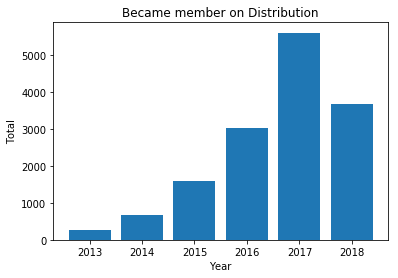

In [34]:
plt.bar(subscription_year['became_member_on'],subscription_year['id'])
plt.title('Became member on Distribution')
plt.xlabel('Year')
plt.ylabel('Total')
plt.show()

The plot has shown that the number of new users increased yearly in general. Also,The highest numbers of new users are in the second half of 2017 with more than 5000 users.

In [35]:
bins = [30000,40000,50000,60000,70000,80000,90000,100000,120000]
labels = ['30K-39K', '40K-49K', '50K-59K','60K-69K', '70K-79K', '80K-89K','90K-100K','100K+']
profile['Income_range'] = pd.cut(profile.income, bins, labels = labels)
income_profile = profile.groupby(['Income_range'],as_index=False)['id'].count()
income_profile

,Income_range,id
0,30K-39K,2047
1,40K-49K,1899
2,50K-59K,2659
3,60K-69K,2347
4,70K-79K,2220
5,80K-89K,1371
6,90K-100K,1188
7,100K+,1006


Text(0,0.5,'Total')

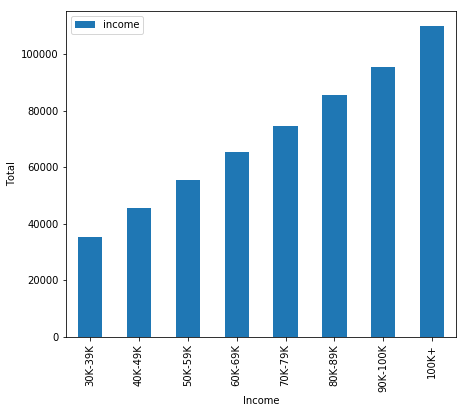

In [36]:
df_pivot = pd.pivot_table(profile,values="income",index="Income_range",aggfunc=np.mean)
ax = df_pivot.plot(kind="bar")
fig = ax.get_figure()
fig.set_size_inches(7, 6)
ax.set_xlabel("Income")
ax.set_ylabel("Total")

On the "Customer's income range" histogram, we can see that the highest total is + 100K for Customer's for this dataset.

In [37]:
profile.head()

,age,became_member_on,gender,id,income,male,female,age_range,Income_range
1,55,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,1,60-69,100K+
3,75,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,+80,90K-100K
5,68,2018,M,e2127556f4f64592b11af22de27a7932,70000.0,1,0,70-79,60K-69K
8,65,2018,M,389bc3fa690240e798340f5a15918d5c,53000.0,1,0,70-79,50K-59K
12,58,2017,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1,0,60-69,50K-59K


### 1.3 Transcript Dataset

### Show Data

In [38]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### Data Shape

In [39]:
transcript.shape # Show the shape of the dataset

(306534, 4)

### Data Types

In [40]:
transcript.info() # Show the data_types of features 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Data Completeness

In [41]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

There no missing value is portfolio dataset.

In [42]:
transcript["event"].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

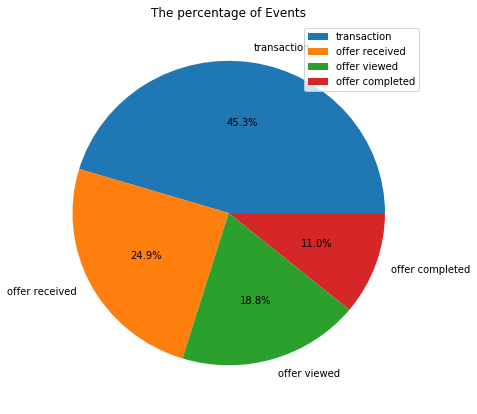

In [43]:
count_test = transcript['event'].value_counts()
labels = transcript['event'].value_counts().index
plt.figure(figsize=(7,7))
plt.pie(count_test, labels=labels, autopct='%1.1f%%')
plt.legend(labels)
plt.title("The percentage of Events")
plt.show()

The graph shows that transaction have the highest percentage of event and they represent 45% then followed by offer received with 25% then offer viewed and offer completed.   

### Data cleaning, Preprocessing, and feature extraction

### Transcript _Clean (copy of Transcript Dataset):

The cleaning and preprocessing of Transcript _Clean is performed as follow :
- The first step is to encoded offer_id , amount and reward in value column so there will 3 new columns : offer_id ,amount and reward.
- Add offer_completed column. For example, offer_completed  = 1 means the offer event is offer completed.
- drop value column.
- Change the names of offer_id to be more readable.

In [44]:
# Finding keys in value column
keys = set()
for val in transcript.value:
    keys.update(val.keys())
keys

{'amount', 'offer id', 'offer_id', 'reward'}

In [45]:
transcript_clean = transcript.copy()

###################################
# Get the offer_id data from the value column 
###################################
transcript_clean['offer_id'] = [[*v.values()][0]
                                    if [*v.keys()][0] in ['offer id',
                                                          'offer_id'] else 0
                                    for v in transcript_clean.value] 
###################################
# Get the transaction amount data from the value column
###################################
transcript_clean['amount'] = [np.round([*v.values()][0], decimals=2) 
                                  if [*v.keys()][0] == 'amount' else 0
                                  for v in transcript_clean.value] 
###################################
# Get the transaction reward data from the value column
###################################
transcript_clean['reward'] = [np.round([*v.values()][0], decimals=2)
                                  if [*v.keys()][0] == 'reward' else 0
                                  for v in transcript_clean.value] 

In [46]:
transcript_clean.drop('value',inplace=True,axis=1) # drop the value column

In [47]:
transcript_clean.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


In [48]:
transcript_clean = transcript_clean.loc[transcript_clean.event.isin(['offer completed', 'offer received'])]

In [49]:
#  completed offers with person and offer as columns 
completed_offers = transcript_clean[transcript_clean.event == 'offer completed' ][['person','offer_id']]

# incompleted offers
incompleted_offers = np.logical_not(transcript_clean.person.isin(completed_offers.person) & transcript_clean.offer_id.isin(completed_offers.offer_id))

In [50]:
# update in value events to incompleted
transcript_clean.loc[incompleted_offers,'event'] = 'offer incompleted'

# remove duplicated rows
transcript_clean = transcript_clean[transcript_clean.event != 'offer received']

In [51]:
transcript_clean.insert(2,'offer_completed',transcript.event.apply(lambda x: 1 if 'offer completed' in x else 0))

In [52]:
transcript_clean.drop('event',inplace=True,axis=1) # drop the value column

In [53]:
transcript_clean.head()

,person,offer_completed,time,offer_id,amount,reward
1,a03223e636434f42ac4c3df47e8bac43,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,0,3f207df678b143eea3cee63160fa8bed,0.0,0
10,744d603ef08c4f33af5a61c8c7628d1c,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0


In [54]:
# Change the names of offer_id to be more readable. 
offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'BOGO_1','4d5c57ea9a6940dd891ad53e9dbe8da0': 'BOGO_2',
      '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'BOGO_3','f19421c1d4aa40978ebb69ca19b0e20d': 'BOGO_4',
      '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'Discount_1','2298d6c36e964ae4a3e7e9706d1fb8c2': 'Discount-2',
      'fafdcd668e3743c1bb461111dcafc2a4': 'Discount_3','2906b810c7d4411798c6938adc9daaa5': 'Discount_4',
      '3f207df678b143eea3cee63160fa8bed': 'Info_1','5a8bc65990b245e5a138643cd4eb9837': 'info_2'}
transcript_clean.offer_id = transcript_clean.offer_id.apply(lambda x: id[x] if x else None)

In [55]:
transcript_clean.offer_completed.value_counts()

1    33579
0    29198
Name: offer_completed, dtype: int64

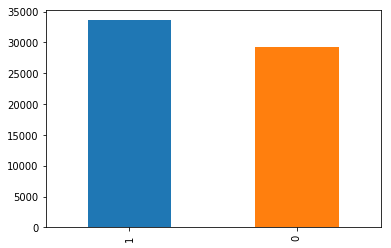

In [56]:
transcript_clean.offer_completed.value_counts().plot(kind='bar')

On the above graph, we can see that the offers are mostly completed.

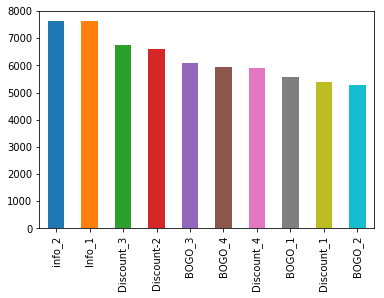

In [57]:
transcript_clean.offer_id.value_counts().plot(kind='bar')

We can see from the above graph that Info_2 , Info_1 and Discounts_3 are the most common offers id that used.

### Merge the dataframes

Merge the three data sets into one

The cleaning and preprocessing of final_data is performed as follow :
- merge Transcript _Clean and profile dataframes.
- drop duplicate customer value and id columns.
- merge Transcript _Clean, profile and portfolio dataframes.
- drop 'reward_y' column.
- check and remove all missing data.

In [58]:
transcript_clean = transcript_clean.rename(columns={'person':'person_id'})

In [59]:
# merge transcript_clean and profile dataframes
transcript_profile = pd.merge(transcript_clean, profile, left_on=['person_id'], right_on = ['id'], how ='left')

#drop duplicate customer id columns
transcript_profile.drop(['id'], axis=1, inplace=True)

#merge transcript, profile and portfolio dataframes
final_data = pd.merge(transcript_profile, portfolio, left_on=['offer_id'], right_on = ['id'], how ='left')\
                .drop('id', axis=1)

In [60]:
final_data.drop(['reward_y'],axis=1,inplace=True)

In [61]:
final_data.head()

,person_id,offer_completed,time,offer_id,amount,reward_x,age,became_member_on,gender,income,...,age_range,Income_range,difficulty,duration,offer_type,social,web,mobile,email,offer_Number
0,a03223e636434f42ac4c3df47e8bac43,0,0,Discount_1,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,20,10,discount,0,1,0,1,offer_5
1,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,Discount_3,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,10,10,discount,1,1,1,1,offer_7
2,68617ca6246f4fbc85e91a2a49552598,0,0,BOGO_2,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,10,5,bogo,1,1,1,1,offer_2
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,Info_1,0.0,0,58.0,2017.0,M,51000.0,...,60-69,50K-59K,0,4,informational,0,1,1,1,offer_3
4,744d603ef08c4f33af5a61c8c7628d1c,0,0,Discount_1,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,20,10,discount,0,1,0,1,offer_5


In [62]:
final_data.dropna(subset = ["age"], inplace=True)

In [63]:
final_data.head()

,person_id,offer_completed,time,offer_id,amount,reward_x,age,became_member_on,gender,income,...,age_range,Income_range,difficulty,duration,offer_type,social,web,mobile,email,offer_Number
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,Info_1,0.0,0,58.0,2017.0,M,51000.0,...,60-69,50K-59K,0,4,informational,0,1,1,1,offer_3
6,c27e0d6ab72c455a8bb66d980963de60,0,0,Info_1,0.0,0,78.0,2017.0,F,71000.0,...,+80,70K-79K,0,4,informational,0,1,1,1,offer_3
7,02c083884c7d45b39cc68e1314fec56c,0,0,BOGO_1,0.0,0,20.0,2016.0,F,30000.0,...,20-29,NaN,10,7,bogo,1,0,1,1,offer_1
8,be8a5d1981a2458d90b255ddc7e0d174,0,0,info_2,0.0,0,39.0,2014.0,M,51000.0,...,40-49,50K-59K,0,3,informational,1,0,1,1,offer_8
10,a5a6ef2b78a04ddc9f374dd7c7f60bff,0,0,info_2,0.0,0,75.0,2015.0,M,52000.0,...,+80,50K-59K,0,3,informational,1,0,1,1,offer_8


Created a copy from the final_data Dataset and dropped all categorical fields to be able to build a machine learning model

In [64]:
cleaned_final_data = final_data.drop(['person_id','gender','offer_type','offer_Number'
                                      ,'offer_id','became_member_on','age_range','Income_range'],axis=1)

In [65]:
cleaned_final_data.head()

,offer_completed,time,amount,reward_x,age,income,male,female,difficulty,duration,social,web,mobile,email
3,0,0,0.0,0,58.0,51000.0,1.0,0.0,0,4,0,1,1,1
6,0,0,0.0,0,78.0,71000.0,0.0,1.0,0,4,0,1,1,1
7,0,0,0.0,0,20.0,30000.0,0.0,1.0,10,7,1,0,1,1
8,0,0,0.0,0,39.0,51000.0,1.0,0.0,0,3,1,0,1,1
10,0,0,0.0,0,75.0,52000.0,1.0,0.0,0,3,1,0,1,1


## And Now let's Answer on some of the questions of our Business Problem

### Q1: Which gender spends more men or Female?

In [66]:
Male = profile[profile['gender']=='M']
Female = profile[profile['gender']=='F']

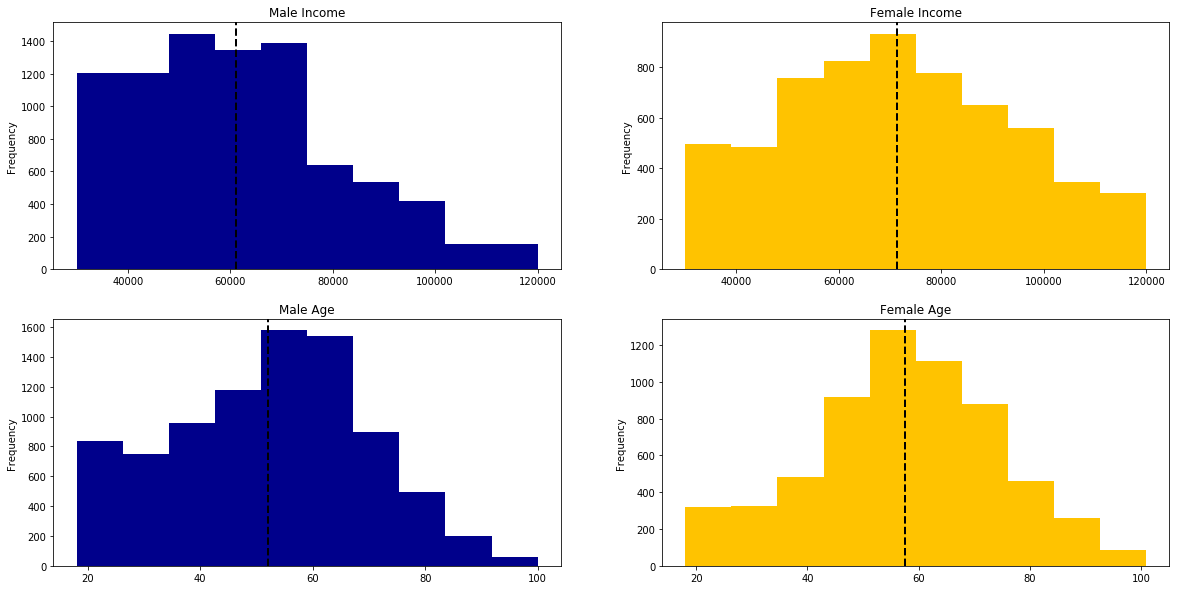

In [67]:
plt.figure(figsize=(20, 10));
plt.subplot(2, 2, 1)
#######
Male['income'].plot(kind='hist', title = 'Male Income', color='#00008B');
plt.axvline(Male.income.mean(), color='k', linestyle='dashed', linewidth=2);
#######
plt.subplot(2, 2, 2)
Female['income'].plot(kind='hist', title = 'Female Income', color = '#FFC300');
plt.axvline(Female.income.mean(), color='k', linestyle='dashed', linewidth=2);
#######
plt.subplot(2, 2, 3)
Male['age'].plot(kind='hist', title = 'Male Age', color = '#00008B');
plt.axvline(Male.age.mean(), color='k', linestyle='dashed', linewidth=2);
####### "#D72424","#FFC300"
plt.subplot(2, 2, 4)
Female['age'].plot(kind='hist', title = 'Female Age', color = '#FFC300');
plt.axvline(Female.age.mean(), color='k', linestyle='dashed', linewidth=2);

The minimum and maximum incomes for males and females are the same, however the male income starts to flatten out towards the high incomes. And as you can see from the dashed line, the average income for women is higher than the average income for men.

### Q2: Which gender became a member more than the other?

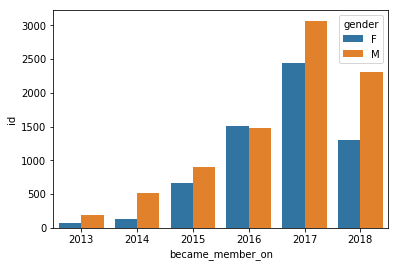

In [68]:
gender_count = profile[profile['gender']!='O'].groupby(['gender','became_member_on']).agg({'id':'count'}).reset_index()
sns.barplot(x='became_member_on', y='id', hue = 'gender', data = gender_count)

Membership has increased over the years. Also, male membership is greater than the female membership every year

### Q3: What is the most popular channels for each offer Types ?

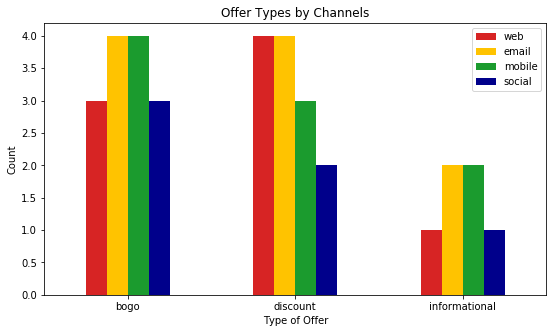

In [69]:
fig, ax = plt.subplots(figsize=(9,5))

portfolio.groupby('offer_type').sum()[['web', 'email', 'mobile', 'social']]\
.plot(kind='bar', ax=ax, color=["#D72424","#FFC300","#1B9B2E","#00008B"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Offer Types by Channels')
ax.set_ylabel('Count')
ax.set_xlabel('Type of Offer'); # bat chart to show all Type of Offer by Channels

In general, the graph shows : 
- The most popular channels for bogo offers : email and mobile.
- The most popular channels for discount offers : email and web.
- The most popular channels for informational offers : email and mobile.

### Q4 :Which offer number is the most completed ? 

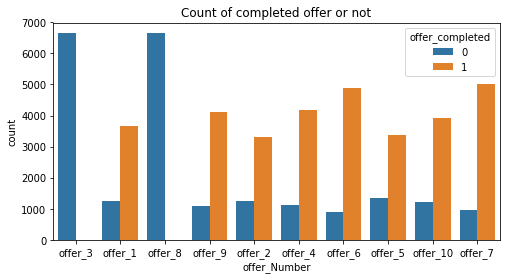

In [70]:
fig = plt.figure(figsize=(8,4))
sns.countplot(x='offer_Number',hue='offer_completed',data=final_data)
plt.title('Count of completed offer or not')
plt.show();

From the chart we can say that the most completed offer is offer_7 followed by offer_6

### Q5 :What is the gender of the most completed offer?

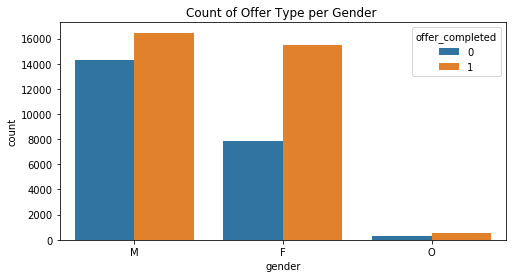

In [71]:
fig = plt.figure(figsize=(8,4))
sns.countplot(x='gender',hue='offer_completed',data=final_data)
plt.title('Count of Offer Type per Gender ')
plt.show();

According to this graph, males complete offers are greater than females

### Data Modeling

### Train and test data sets

In [72]:
X = cleaned_final_data.iloc[:,1:] # select features 
y = cleaned_final_data.iloc[:,0] # select target feature 

In [73]:
#  set the train and test  with the test_size 0.3 and random state is 5
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=5) 

### Scaling train and test data

In [74]:
ss = StandardScaler() # Scaling data
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

### Building model

In [75]:
def build_model(model,model_name,y_test=y_test,y_train=y_train):
    """
    INPUT:
    model -  model
    model_name - a name of model
  
    OUTPUT:
    accuracy_score_train  (int) - accuracy score for the train dataset
    accuracy_score_test (int) - accuracy score for the test dataset
    """

    model.fit(Xs_train, y_train) # Fit train data into model

    # Predict y train and test
    y_pred_train = model.predict(Xs_train)
    y_pred_test = model.predict(Xs_test)

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('THe Test Confusion Matrix of - '+model_name)
    plt.show()
    
    print("Accuracy Score of "+model_name+f": {accuracy_score(y_train,y_pred_train)}")
    print("Accuracy Score of "+model_name+f": {accuracy_score(y_test,y_pred_test)}")

    return accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)

### Decision Tree

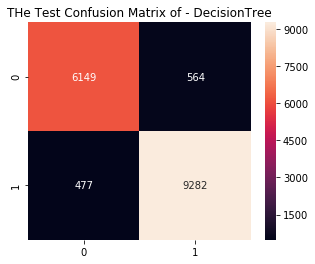

Accuracy Score of DecisionTree: 0.9993755528958734
Accuracy Score of DecisionTree: 0.9368018455560952


In [79]:
# decisiontree Model
decisiontree = DecisionTreeClassifier()

# build model and show accuracy score of train and test dataset
accuracy_score_train, accuracy_score_test = build_model(decisiontree,"DecisionTree")

train_score = {}
test_score = {}

train_score['DecisionTree'] = accuracy_score_train
test_score['DecisionTree'] = accuracy_score_test

### Random Forest

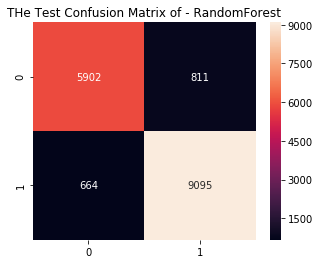

Accuracy Score of RandomForest: 0.995498777124421
Accuracy Score of RandomForest: 0.9104541039339485


In [84]:
randomforest = RandomForestClassifier() # RandomForest Model

# build model and show accuracy score of train and test dataset
accuracy_score_train, accuracy_score_test = build_model(randomforest,"RandomForest") 

train_score = {}
test_score = {}

train_score['RandomForest'] = accuracy_score_train
test_score['RandomForest'] = accuracy_score_test

### Logistic Regression

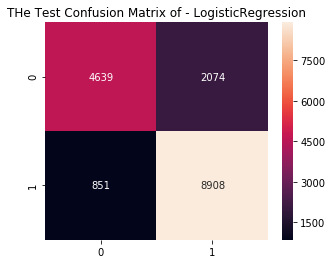

Accuracy Score of LogisticRegression: 0.8220846125826091
Accuracy Score of LogisticRegression: 0.822425934919864


In [80]:
logisticregression = LogisticRegression() # Logistic Regression Model

# build model and show accuracy score of train and test dataset

accuracy_score_train, accuracy_score_test = build_model(logisticregression,"LogisticRegression") 

train_score = {}
test_score = {}

train_score['LogisticRegression'] = accuracy_score_train
test_score['LogisticRegression'] = accuracy_score_test

### Model Summary

Several models have been developed to predict whether or not an offer will be accepted. The accuracy of all models is high since the lowest accuracy is 84.4%, and only Decision Tree and Random Forest have overfitting issues. As a result, those models perform well in train-sets and produce more errors in test-sets (unseen data). In order to solve this issue, we will tune the decision tree parameters, experiment with different training and testing splits, and analyze the set of features to find the most optimal ones.

### Conclusion 

Starbucks is one of the best-known companies in the food and beverage industry. As a summary of the findings, the number of app users has increased dramatically in 2016 and 2017. As well, users who spend more time on an offer are more likely to complete it. Most of the new or old users are male and enjoy discount offers the most, whereas most females dislike discounts and BOGOs. Also, email is a great way to send offers. Discounts feature a long duration in comparison to other types. 

I developed a machine learning model to predict whether or not users are going to complete the offer to support the marketing team in selecting the highest potential clients. Costs will be saved on finding influenced customers.

Additionally, if more customer metrics were collected, better predictions would have been made. During this analysis, we only had access to age, gender, and income information about the customer. A few more features of a customer would be useful to find optimal customer demographics. These additional features may aid in providing better classification model results.